In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
import os
from datetime import datetime
from datetime import timedelta

#### Fixed variables

In [51]:
# store map size (pixels)
STORE_SIZE = [3136, 2475]

# camera origin point in store map
CAMERA_ORIGIN_POINT = {"1.03": (1079, 1219), "1.04": (1075, 1410), "1.05": (1125, 1380), "2.05": (998, 1663)}

# dimensoes da imagem apenas com a projeção dos pontos de cada camara
CAMERA_PROJECTION_SIZE = {"1.03": (500, 560), "1.04": (900, 450), "1.05": (460, 400), "2.05": (460, 380)}

#hora de inicio de gravação da camara
CAMERA_STARTING_TIME = {"1.03": "09:19:33", "1.04": "07:48:01", "1.05": "07:12:50", "2.05": "07:50:30"}

SAVE_IMG_PATH = "results/images/printed_coords.png"
SAVE_CSV_PATH = "results/trajectories/transformed_coords.csv"
TRAJECTORY_DATA_PATH = "C:/Users/diogo/Desktop/Tese/Dados/trajetorias_novas/14.03.2022/"
MAP_PATH = "C:/Users/diogo/Desktop/Tese/Dados/floorplan.png"


#### Read camera data

In [14]:
def read_camera_data(camera):
    files = os.path.join(TRAJECTORY_DATA_PATH + str(camera), "*.csv")
    files = glob.glob(files)
    data_from_camera = []
    for filename in files:
        df = pd.read_csv(filename, low_memory=False, index_col=None, header=0)
        df["camera"] = camera
        data_from_camera.append(df)
    return pd.concat(data_from_camera, axis=0, ignore_index=True)

#### Read and concatenate data from all cameras

In [15]:
def concatenate_data_all_cameras():
    dir_list = os.listdir(TRAJECTORY_DATA_PATH)
    remove_words = ["teste", ".ipynb_checkpoints", ".DS_Store"]
    camera_list = list(filter(lambda directory: directory not in remove_words, dir_list))

    data_all_cameras = []
    for camera in camera_list:
        files = os.path.join(TRAJECTORY_DATA_PATH + str(camera), "*.csv")
        files = glob.glob(files)
        for filename in files:
            df = pd.read_csv(filename, low_memory=False, index_col=None, header=0)
            df["camera"] = camera
            data_all_cameras.append(df)

    return pd.concat(data_all_cameras, axis=0, ignore_index=True)

def concatenate_data_selected_cameras(camera_list):
    data_all_cameras = []
    for camera in camera_list:
        files = os.path.join(TRAJECTORY_DATA_PATH + str(camera), "*.csv")
        files = glob.glob(files)
        for filename in files:
            df = pd.read_csv(filename, low_memory=False, index_col=None, header=0)
            df["camera"] = camera
            data_all_cameras.append(df)

    return pd.concat(data_all_cameras, axis=0, ignore_index=True)


#### Transformations

In [16]:
def get_min_and_max_values_per_camera(camera_data):
    min_x = min(camera_data["x_floorplan"])
    min_y = min(camera_data["y_floorplan"])
    max_x = max(camera_data["x_floorplan"])
    max_y = max(camera_data["y_floorplan"])
    return min_x, min_y, max_x, max_y

def get_scale_multiplier(min, max, camera_projection_size):
    return camera_projection_size / (max - min)

In [17]:
def transform_coordinates(df):
    for camera in df["camera"].unique():
        origin_x, origin_y = CAMERA_ORIGIN_POINT[camera]
        min_x, min_y, max_x, max_y = get_min_and_max_values_per_camera(df[df["camera"] == camera])
        scale_multiplier_x = get_scale_multiplier(min_x, max_x, CAMERA_PROJECTION_SIZE[camera][0])
        scale_multiplier_y = get_scale_multiplier(min_y, max_y, CAMERA_PROJECTION_SIZE[camera][1])
        df.loc[df.camera == camera, 'x_floorplan_new'] = df['x_floorplan'].map(lambda x: ((x + abs(min_x)) * scale_multiplier_x) + origin_x)
        df.loc[df.camera == camera, 'y_floorplan_new'] = df['y_floorplan'].map(lambda y: ((y + abs(min_y)) * scale_multiplier_y) + origin_y)
        df.loc[df.camera == camera, 'time'] = df.apply(lambda df: calculate_time(get_total_frames(df["video_name"], df["frame_id"], df["camera"]), df["camera"]), axis=1)
    return df


def get_total_frames(video_name, frame, camera):
    video_list = pd.read_csv(f"results/frame_counter/frame_count_{camera}.csv").values.tolist()
    frame_count = 0
    for _, video, n_frames in video_list:
        if video != video_name:
            frame_count += n_frames
        else:
            frame_count += frame
            break
    return frame_count


def calculate_time(total_frames, camera):
    seconds = round(total_frames / 6)
    start_time = datetime.strptime(CAMERA_STARTING_TIME[camera],"%H:%M:%S")
    return (start_time + timedelta(seconds=seconds)).time()


def print_trajectory(df):
    img = plt.imread(MAP_PATH)
    fig, ax = plt.subplots()
    fig.set_dpi(1200)
    ax.imshow(img, extent=[0, STORE_SIZE[0], 0, STORE_SIZE[1]])
    plt.scatter(df["x_floorplan_new"], df["y_floorplan_new"], marker=".", s=1, lw=0, color="blue")
    plt.savefig(SAVE_IMG_PATH, dpi=1200)


### Transformação e Gravação Dados Câmara 1.03

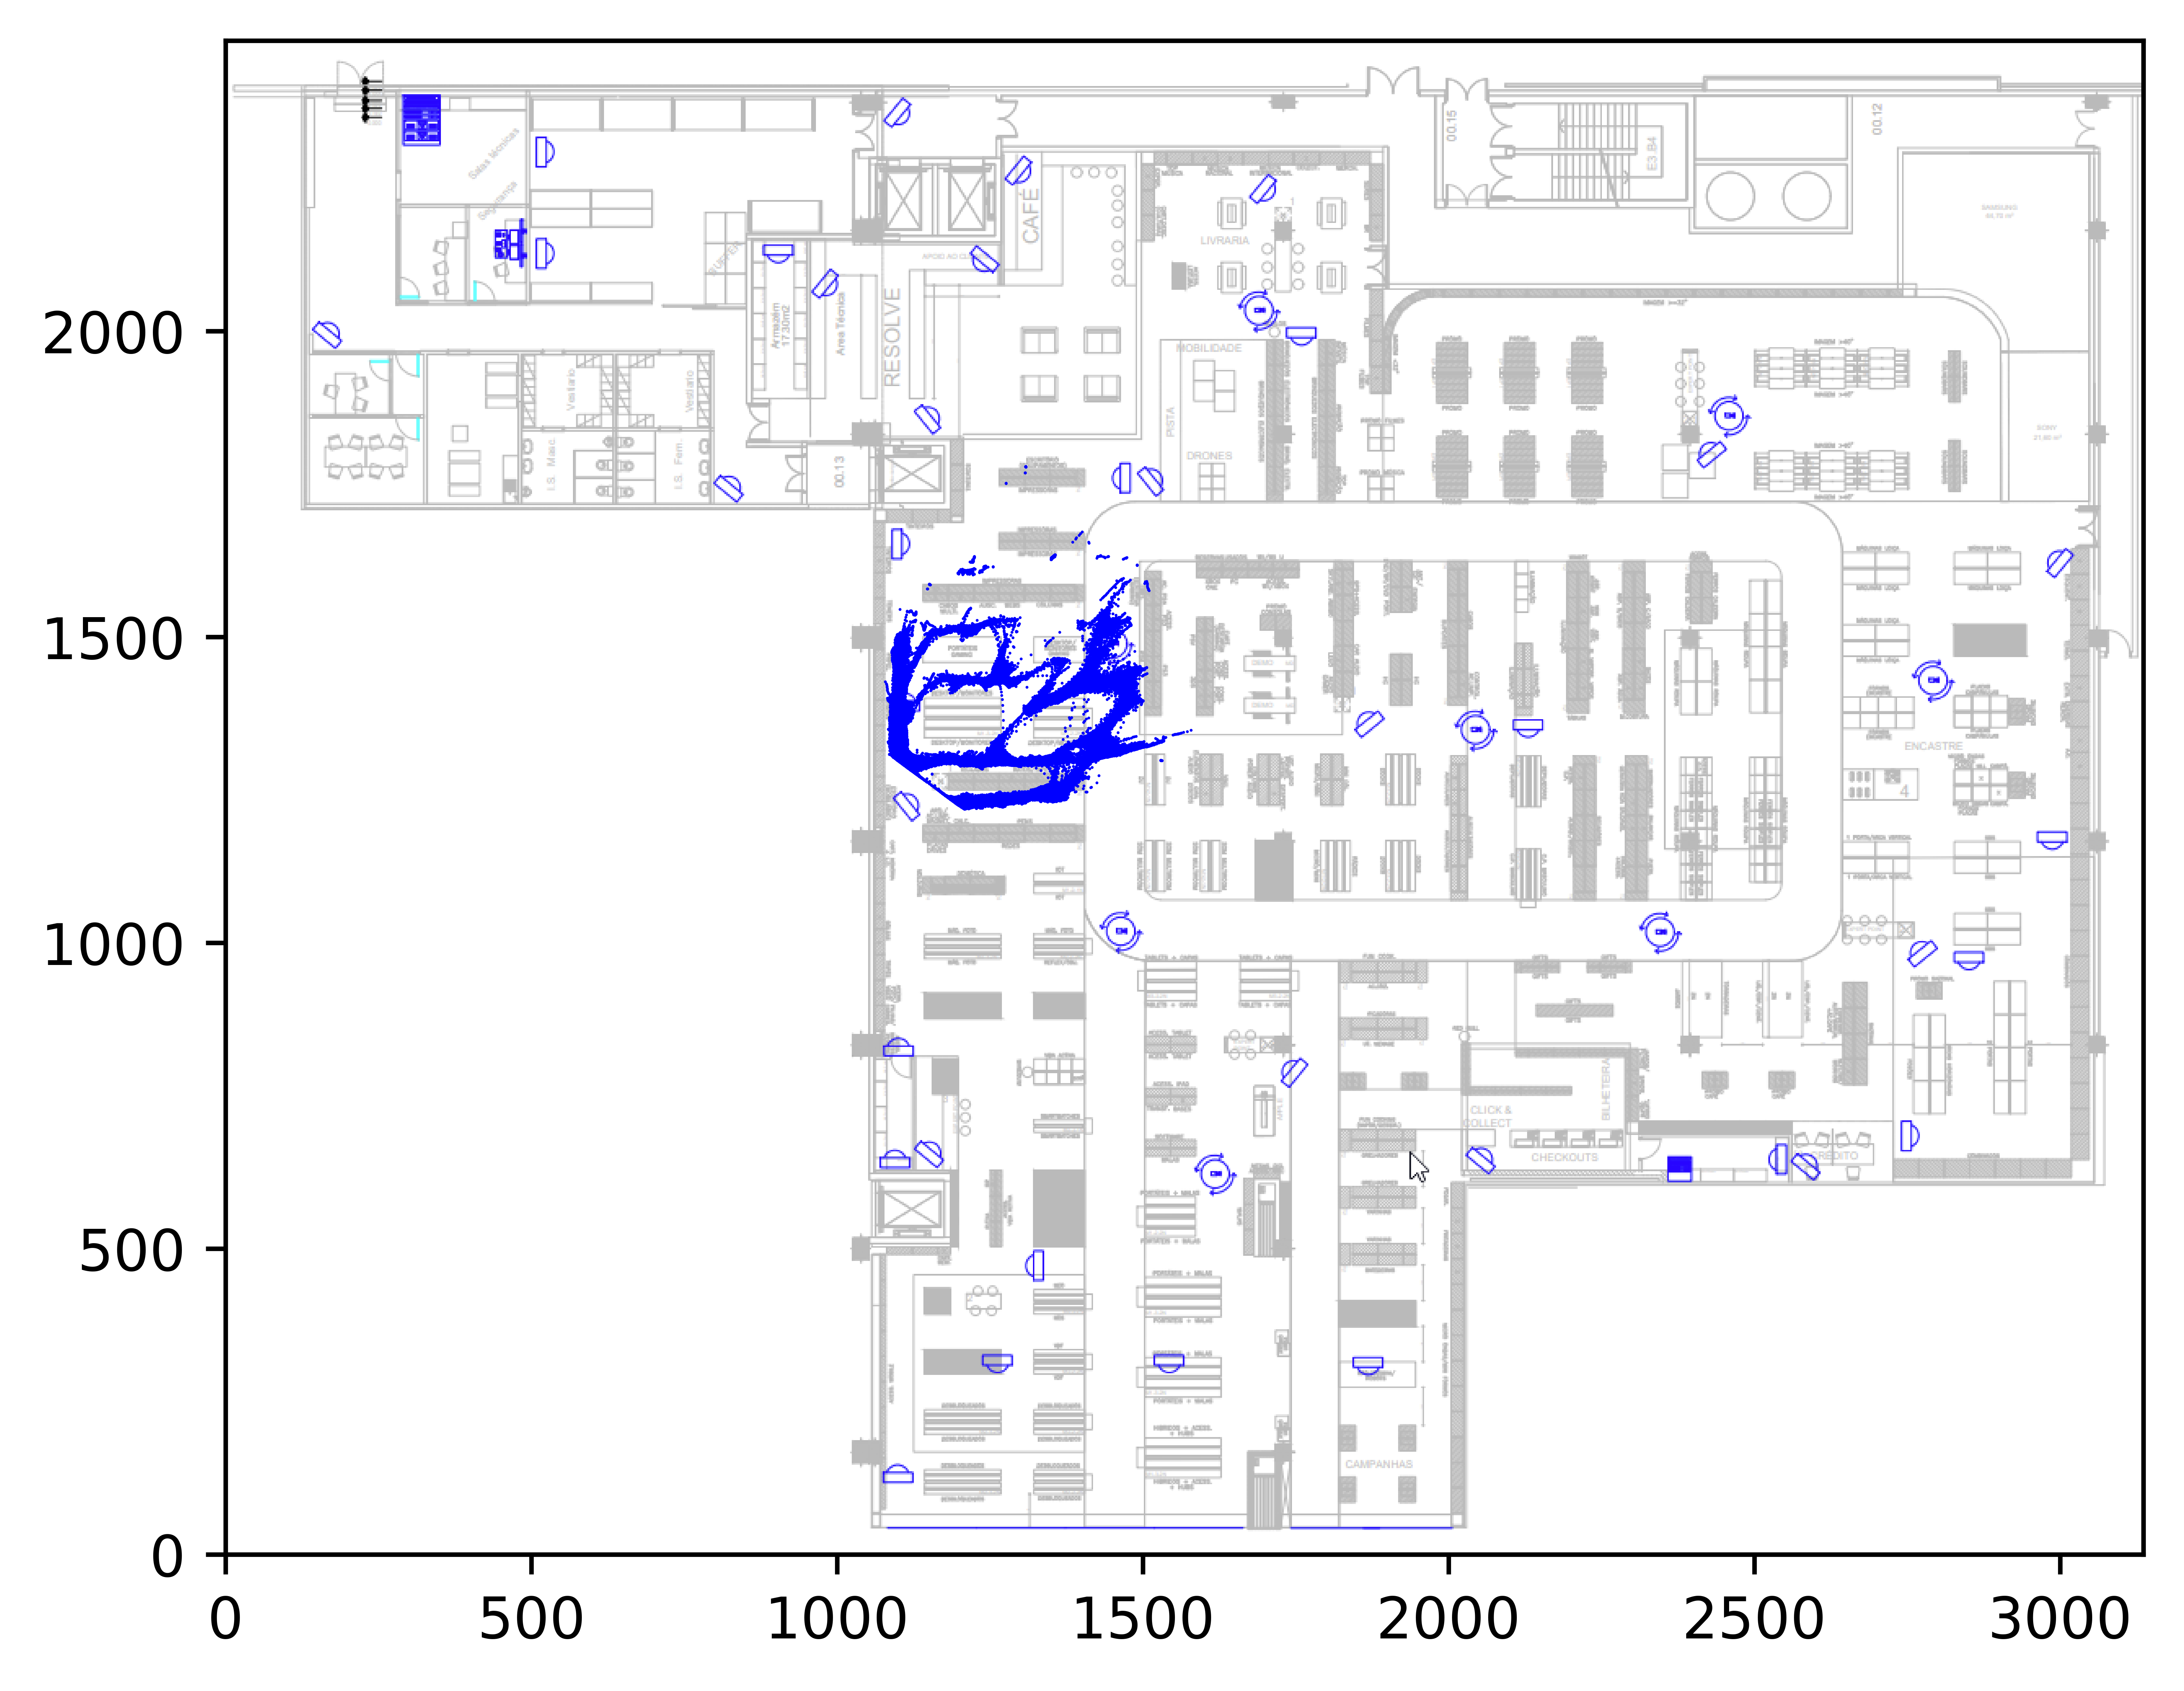

In [21]:
data103 = read_camera_data("1.03")
new_data = transform_coordinates(data103)
new_data.to_csv("results/trajectories/transformed_coords_1.03.csv")
print_trajectory(new_data)

### Transformação e Gravação Dados Câmara 1.04

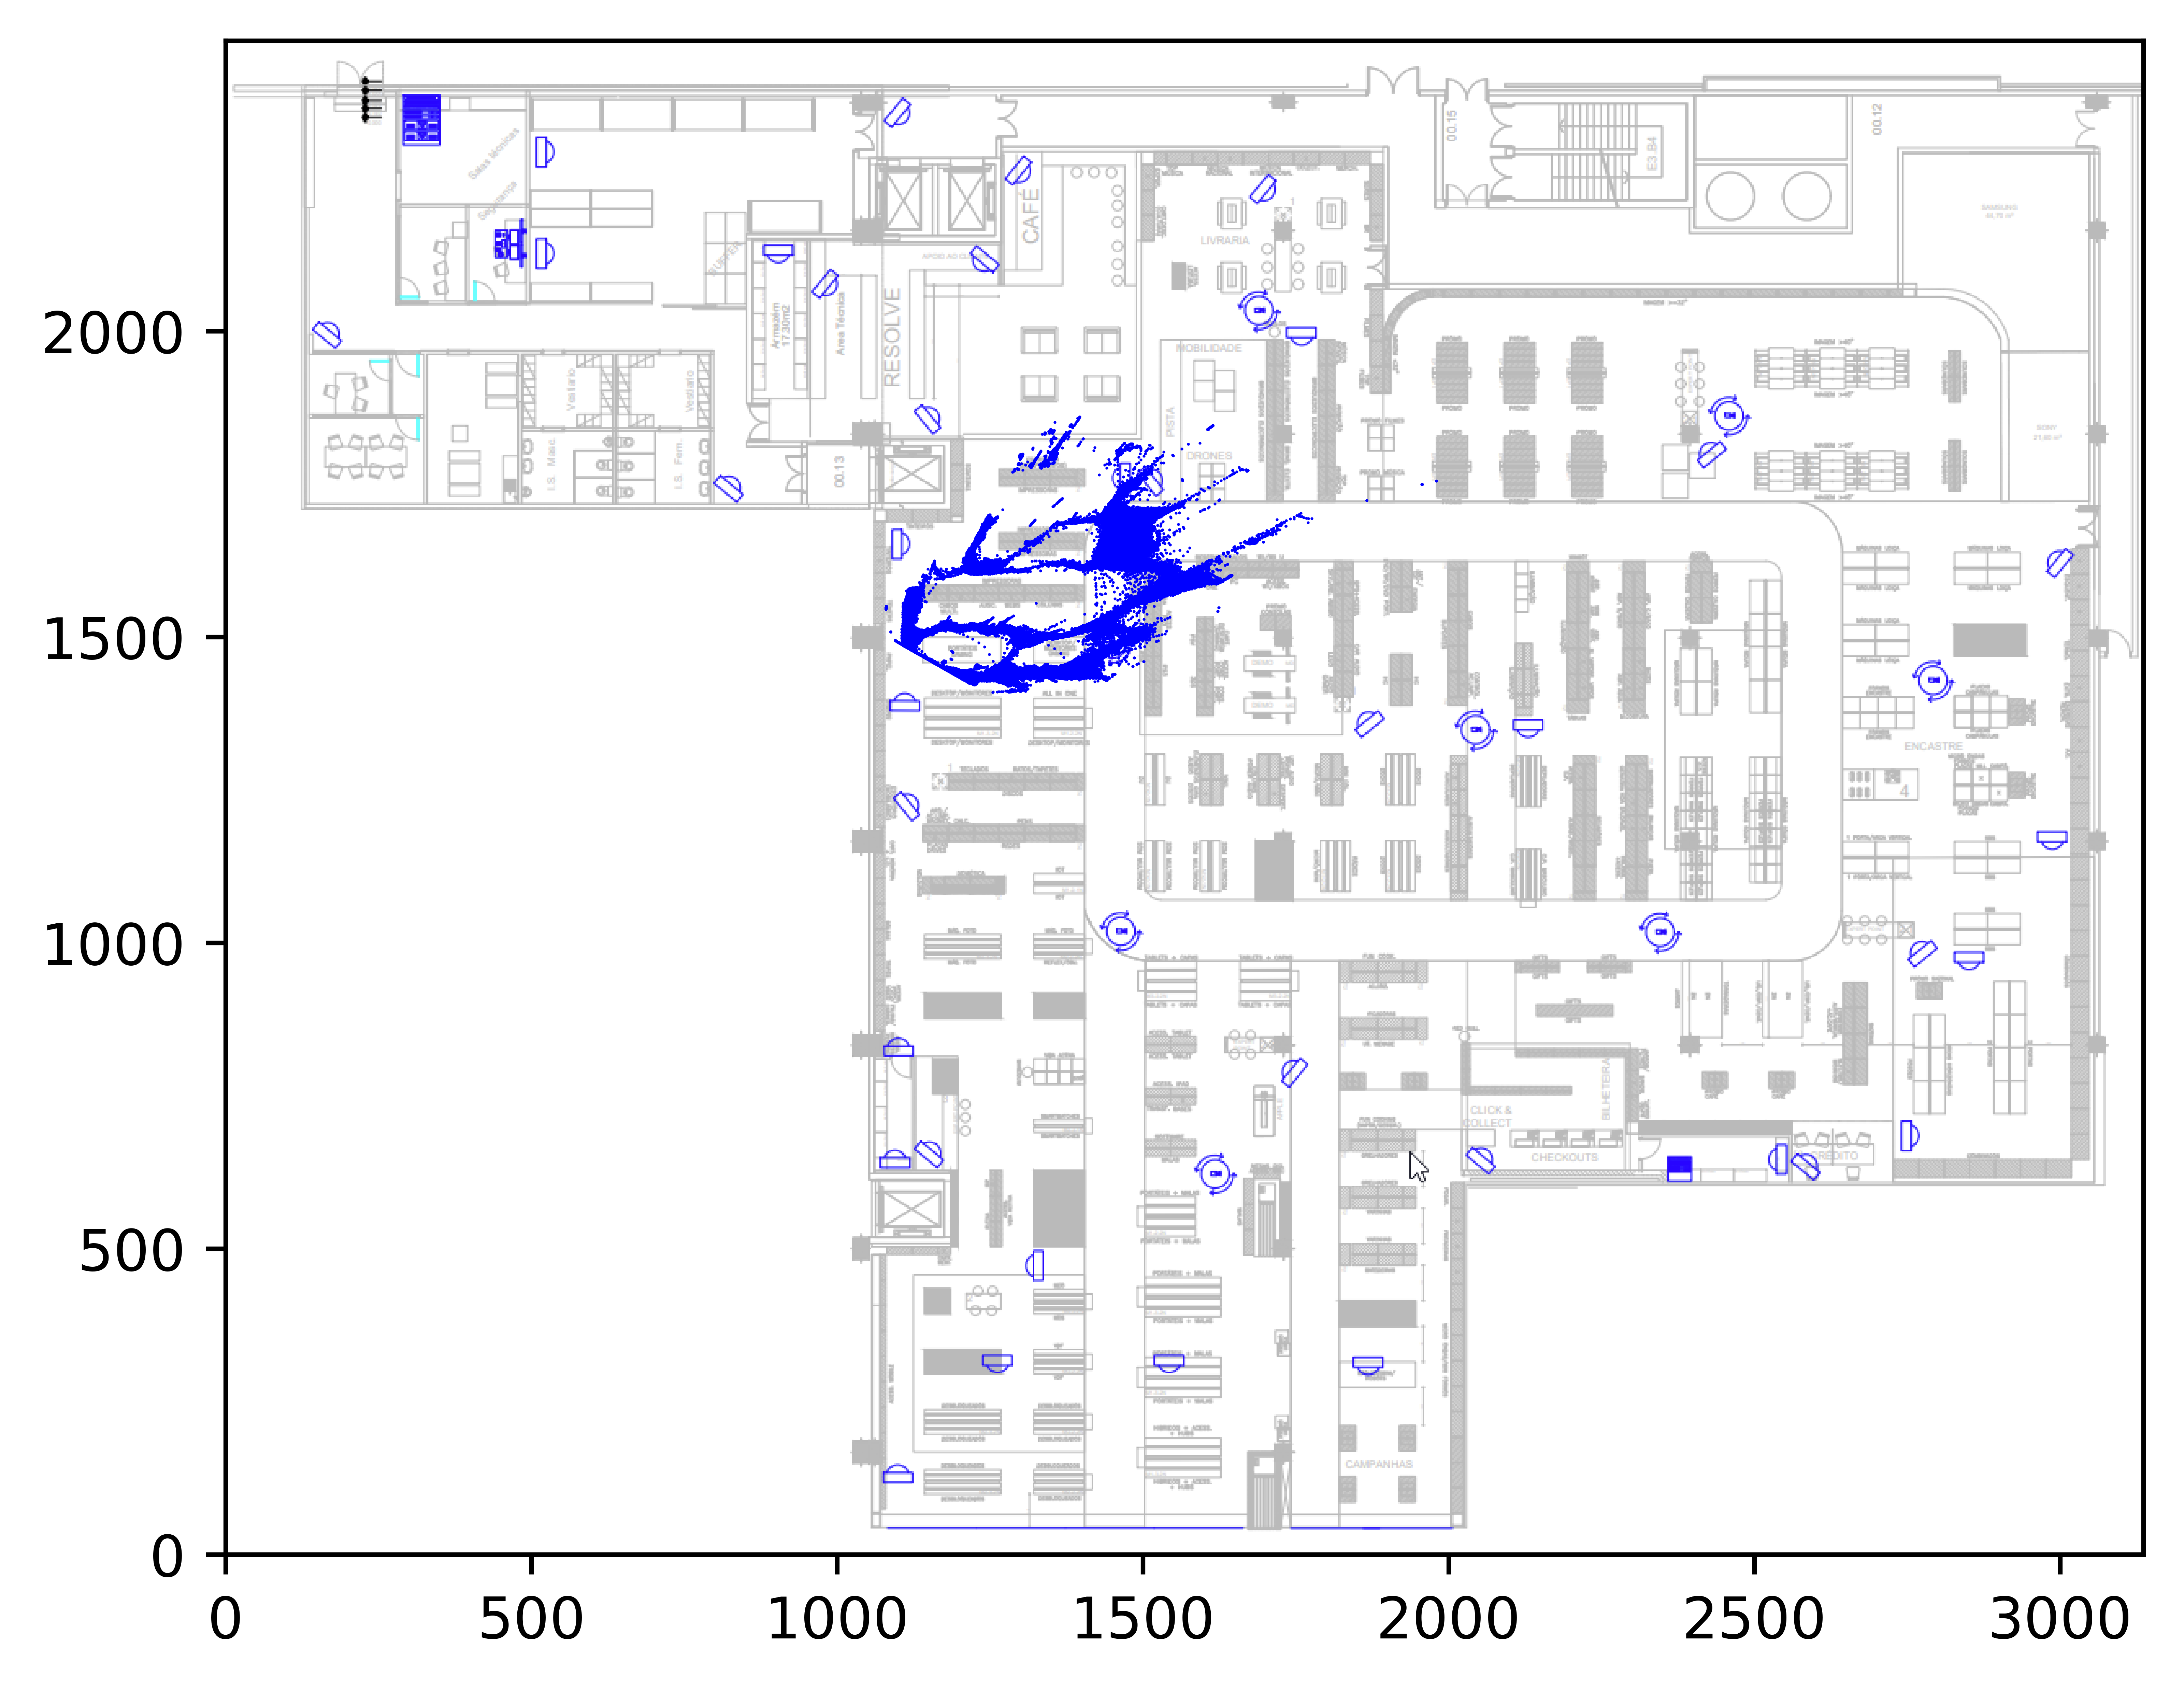

In [43]:
data104 = read_camera_data("1.04")
data104 = transform_coordinates(data104)
data104.to_csv("results/trajectories/transformed_coords_1.04.csv")
print_trajectory(data104)

### Transformação e Gravação Dados Câmara 1.05

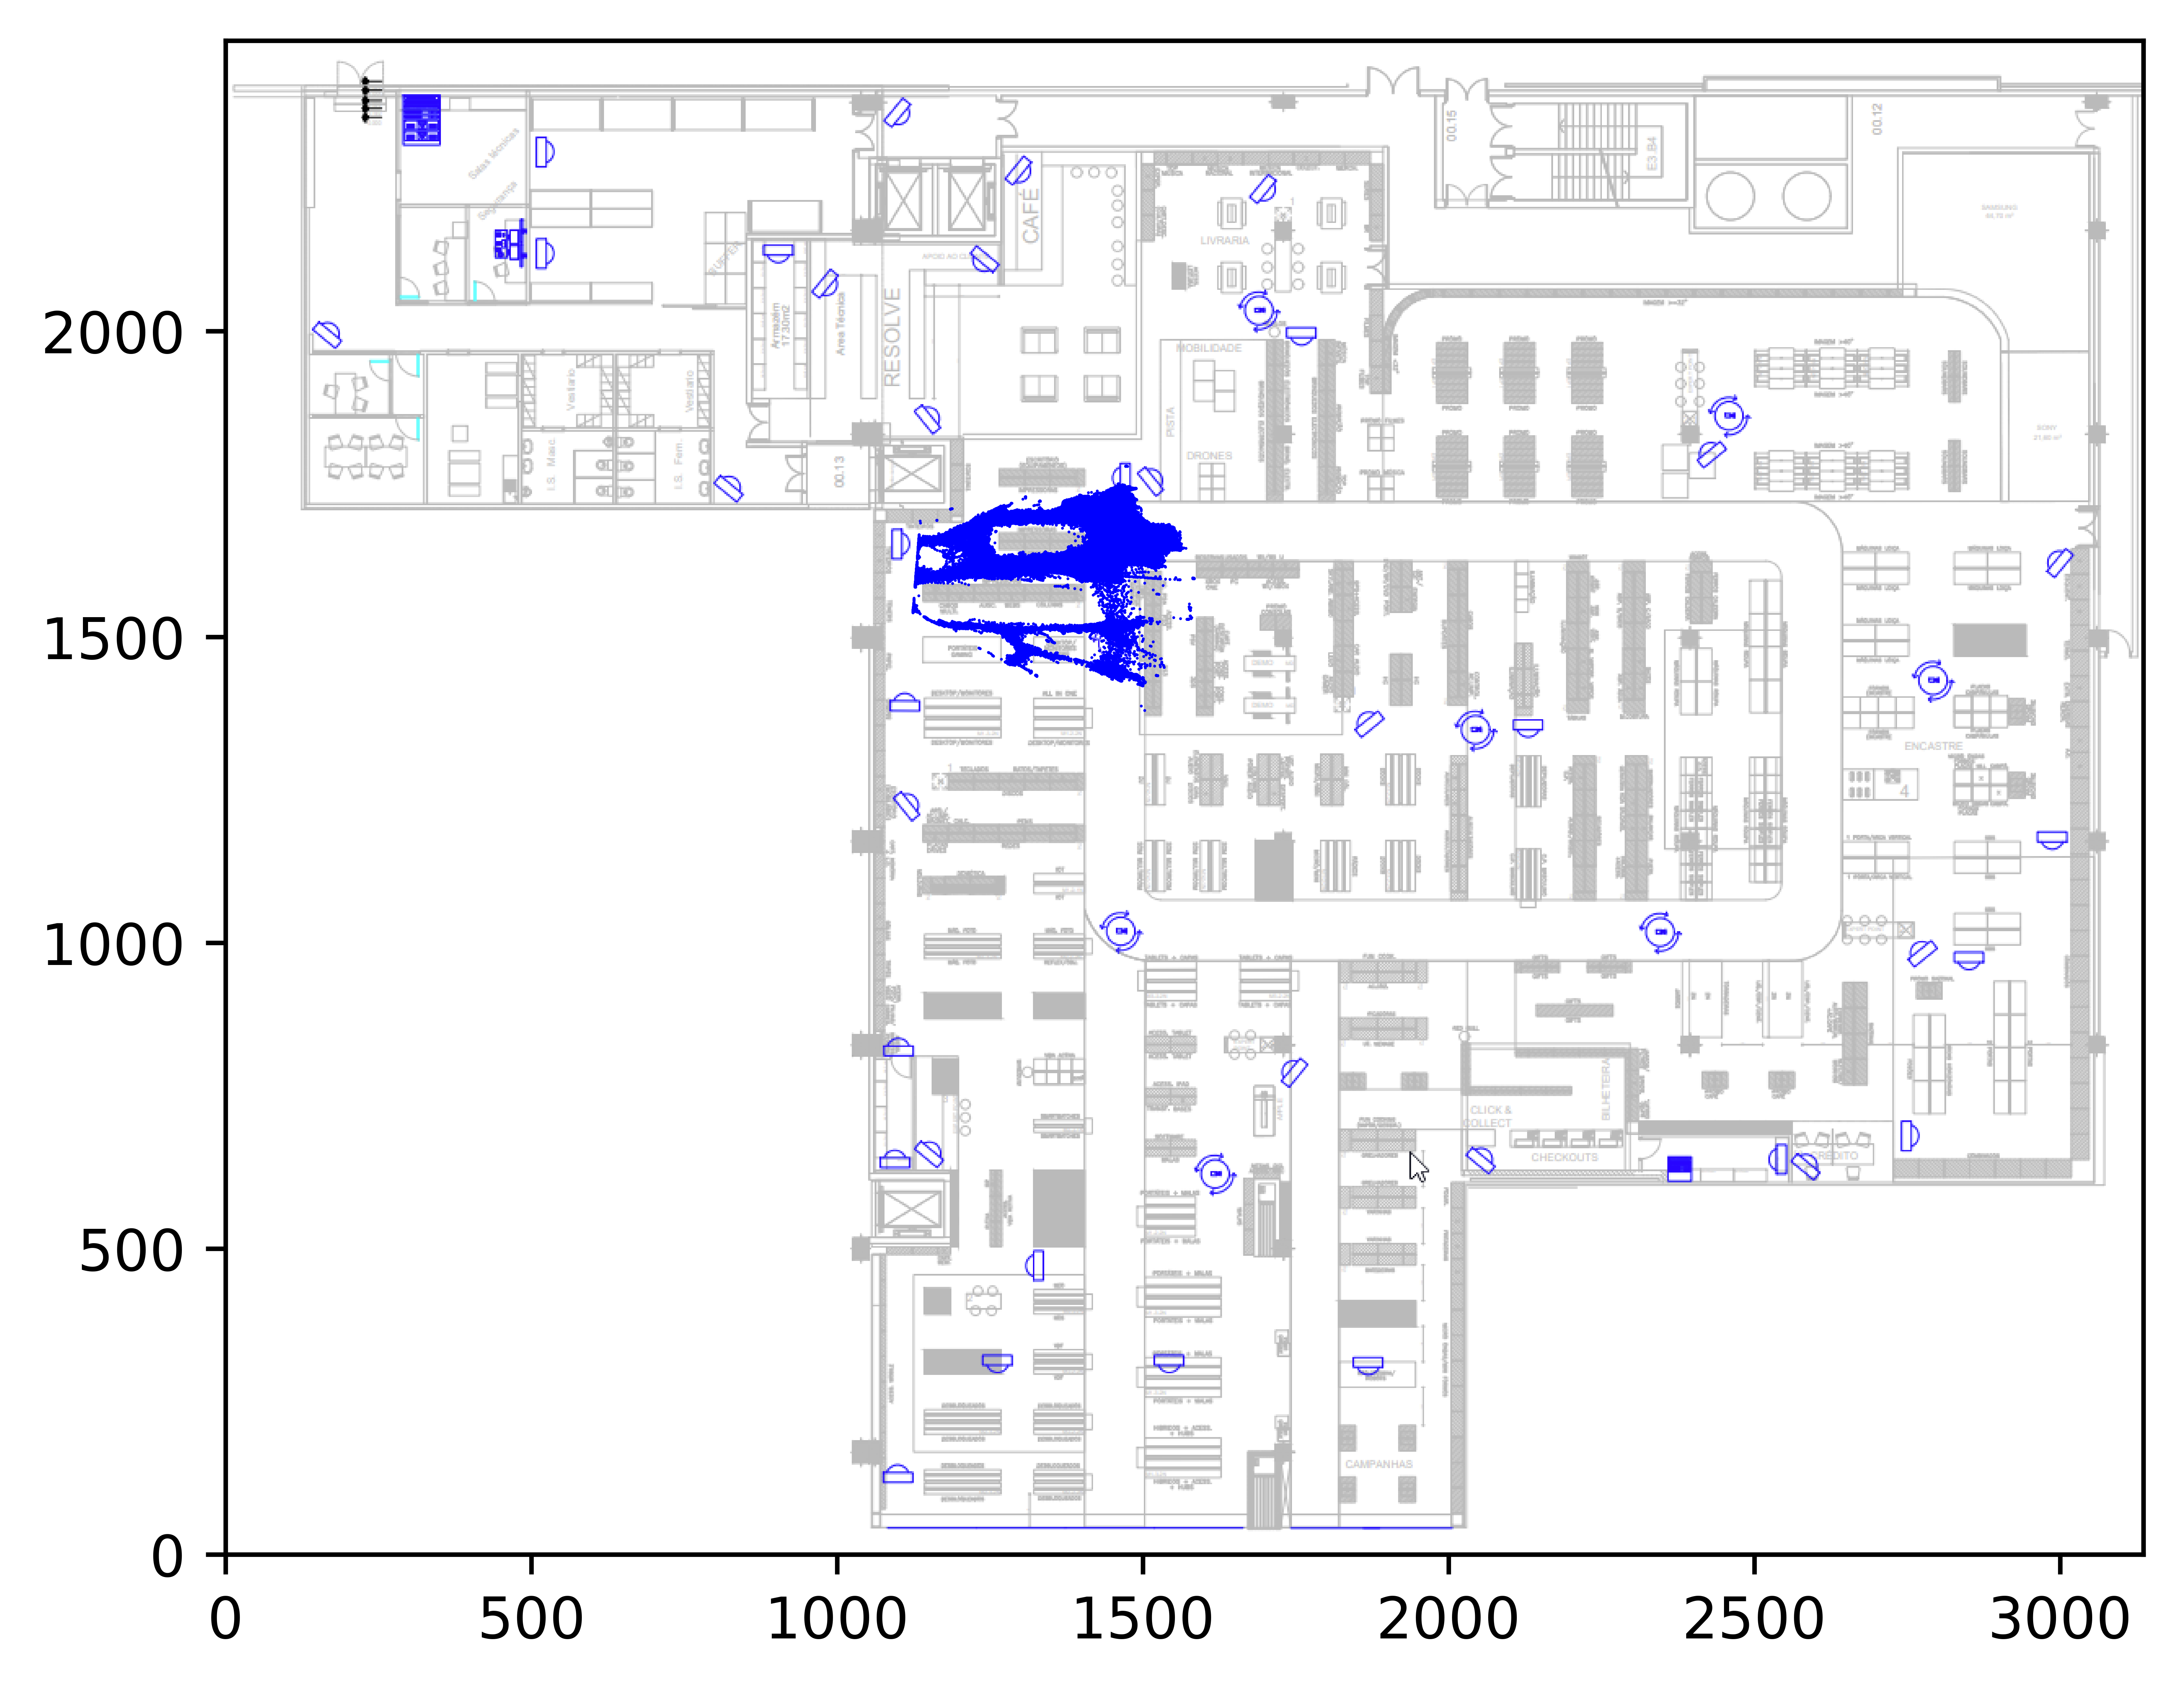

In [50]:
data105 = read_camera_data("1.05")
data105 = transform_coordinates(data105)
data105.to_csv("results/trajectories/transformed_coords_1.05.csv")
print_trajectory(data105)

### Transformação e Gravação Dados Câmara 2.05

In [ ]:
'''data205 = read_camera_data("2.05")
data205 = transform_coordinates(data205)
data205.to_csv("/results/trajectories/transformed_coords_2.05.csv")
print_trajectory(data205)'''

'data205 = read_camera_data("2.05")\ndata205 = transform_coordinates(data205)\ndata205.to_csv("/results/trajectories/transformed_coords_2.05.csv")\nprint_trajectory(data205)'

#### Main - Transformação e Gravação dos dados de todas as Câmaras

In [ ]:
'''all_data = concatenate_data_all_cameras()
new_data = transform_coordinates(all_data)
new_data.to_csv(SAVE_CSV_PATH)
print_trajectory(new_data)'''

'all_data = concatenate_data_all_cameras()\nnew_data = transform_coordinates(all_data)\nnew_data.to_csv(SAVE_CSV_PATH)\nprint_trajectory(new_data)'